<a id="title_ID"></a>

# Creating a simulated starfield image and performing photometry using `webbpsf` and `photutils.GriddedPSFModel`

## Imports

* *matplotlib inline* for creating non-interactive plots
* *numpy* for numerical computations
* *astropy.io.fits* for accessing FITS files
* *astropy.stats.gaussian_sigma_to_fwhm* for converting $\sigma$ to FWHM
* *astropy.table.Table* for constructing Astropy table
* *astropy.utils.misc.NumpyRNGContext* for reproducible random result
* *astropy.visualization* for normalized image display
* *photutils* for photometry related classes and functions
* *webbpsf* for JWST PSF related functions

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.utils.misc import NumpyRNGContext
from astropy.visualization import imshow_norm, PercentileInterval, SqrtStretch
from photutils import BasicPSFPhotometry
from photutils import DBSCANGroup, MMMBackground
from photutils.datasets import make_noise_image
from webbpsf.gridded_library import display_psf_grid
from webbpsf.utils import to_griddedpsfmodel

/Users/etollerud/miniconda3/envs/nb-build/lib/python3.7/site-packages/pysynphot/locations.py:47: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/etollerud/miniconda3/envs/nb-build/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Introduction

The simulated image will be made using a spatially-dependent JWST PSF generated by `webbpsf`.  `photutils` will be then used to perform PSF-fitting photometry on the simulated JWST NIRCam image.

The intended audience are astronomers already familiar with PSF photometry, the FITS file format, and basic Python usage. In-depth scientific and technical backgrounds will not be discussed nor taught in this notebook.

**Background on JWST PSF simulation:** https://jwst.stsci.edu/science-planning/proposal-planning-toolbox/psf-simulation-tool-webbpsf

**Background on PSF photometry:** https://photutils.readthedocs.io/en/stable/psf.html

**Some notes about the file:** It is pre-generated grid of JWST PSFs for NIRCam A1 detector in F090W filter. The file is hosted on STScI Box file sharing system.

**Defining some terms:**

* **F090W:** A NIRCam filter
* **FITS:** Flexible Image Transport System (https://fits.gsfc.nasa.gov/fits_primer.html)
* **HDU:** Header/Data Unit in a FITS file
* **JWST:** James Webb Space Telescope
* **NIRCam:** Near-Infrared Camera on JWST (https://jwst.stsci.edu/instrumentation/nircam)
* **NRCA1:** NIRCam A1 detector
* **PSF:** Point-spread function

## Loading data

We start by loading into FITS HDU a pre-generated grid of JWST PSFs for NIRCam A1 detector in F090W filter.

In [2]:
url = 'https://stsci.box.com/shared/static/6h8wsr2ts0t24s79cxmnyk8bldt0vv3i.fits'
hdu = fits.open(url)

## File information

In [3]:
hdu.info()

Filename: /Users/etollerud/.astropy/cache/download/py3/f9458e6c3ca9c61483d317aa215ba791
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (404, 404, 16)   float64   


Astropy has saved a cached copy of this file under your local cache directory for Astropy; default is `~/.astropy/cache/download`.

This file only has a single extension that holds a data cube. The cube consists of 16 PSF images, each with dimension of 404 by 404 pixels. Each PSF is oversampled by a factor of 4, so the actual detector pixel dimension covered by the PSF is 101 by 101.

Now, let's look at the first PSF in the cube.

(<matplotlib.image.AxesImage at 0x7fe9c459fb10>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7fe9b01deb50>)

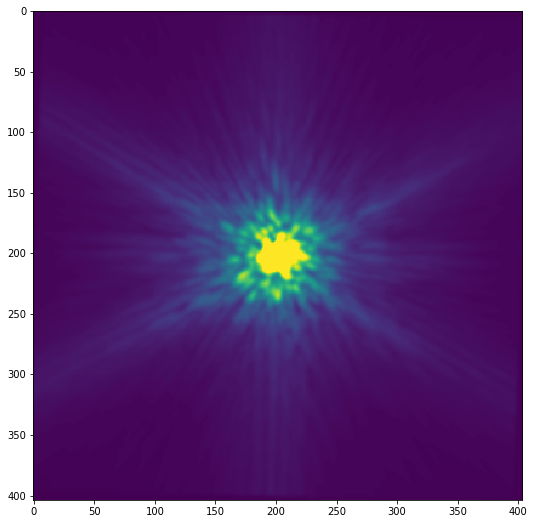

In [4]:
data = hdu[0].data[0]
plt.figure(figsize=(9, 9))
imshow_norm(data, interval=PercentileInterval(99.), stretch=SqrtStretch())

## Creating a PSF model

We now create a `photutils.GriddedPSFModel` from the FITS HDU.

In [5]:
psfmodel = to_griddedpsfmodel(hdu, ext=0)

TypeError: to_griddedpsfmodel() got an unexpected keyword argument 'ext'

In [ ]:
psfmodel

`psfmodel` is an instance of a `photutils.GriddedPSFModel`.  Let's view some of it's attributes.

The oversampled PSF grid is stored internally as a 3D `numpy.ndarray`.  The first axis represents the number of PSFs, while the second and third axes represent the `(ny, nx)` shape of the 2D PSFs.

Here there are 16 PSFs (from a 4x4 reference grid) and the shape of each is 404x404 pixels.

In [ ]:
psfmodel.data.shape

The `oversampling` attribute is the PSF oversampling factor.

In [ ]:
psfmodel.oversampling

The `grid_xypos` attribute contains a list of the `(x, y)` positions of reference PSFs.  The PSF at an arbitrary `(x, y)` position is interpolated from the grid of reference PSFs.

In [ ]:
psfmodel.grid_xypos

This model contains a 4x4 grid of reference PSFs.

In [ ]:
len(psfmodel.grid_xypos)

The `meta` attribute is dictionary holding detailed information how the PSF model grid was generated by `webbpsf`. For example, `psfmodel.meta['fovpixel']` would indicate that "field of view in pixels (full array)" is 101 pixels.

In [ ]:
psfmodel.meta

In [ ]:
fovpixel = psfmodel.meta['fovpixel']
print(fovpixel[1], 'is', fovpixel[0])

We can use the `webbpsf.gridded_library.display_psf_grid` function to visualize the PSF grid.

In [ ]:
display_psf_grid(psfmodel)

## Creating simulated starfield

Now let's use the `psfmodel` grid to create a simulated starfield image. First, we'll define 25 stars with random positions and fluxes. We are using a small image with limited number of stars for faster computation; feel free to use a larger image and/or more stars when you run this notebook locally, if desired.

In [ ]:
shape = (512, 512)
data = np.zeros(shape)
nstars = 25
flux_max = 200000.

with NumpyRNGContext(12345):  # Seed for repeatability
    xx = np.random.uniform(low=0, high=shape[1], size=nstars)
    yy = np.random.uniform(low=0, high=shape[0], size=nstars)
    zz = np.random.uniform(low=0, high=flux_max, size=nstars)

Now we'll evaluate the model at these positions and fluxes.

In [ ]:
eval_xshape = np.int(np.ceil(psfmodel.data.shape[2] / psfmodel.oversampling))
eval_yshape = np.int(np.ceil(psfmodel.data.shape[1] / psfmodel.oversampling))

for xxi, yyi, zzi in zip(xx, yy, zz):
    x0 = np.int(np.floor(xxi - (eval_xshape - 1) / 2.))
    y0 = np.int(np.floor(yyi - (eval_yshape - 1) / 2.))
    x1 = x0 + eval_xshape
    y1 = y0 + eval_yshape
    
    if x0 < 0:
        x0 = 0
    if y0 < 0:
        y0 = 0
    if x1 > shape[1]:
        x1 = shape[1]
    if y1 > shape[0]:
        y1 = shape[0]
        
    y, x = np.mgrid[y0:y1, x0:x1]
    data[y, x] += psfmodel.evaluate(x=x, y=y, flux=zzi, x_0=xxi, y_0=yyi)

Let's add some noise to the image.

In [ ]:
noise = make_noise_image(data.shape, 'gaussian', mean=0, stddev=2, random_state=123)
data += noise

Let's display the simulated JWST NIRCam A1 detector image in F090W filter.

In [ ]:
plt.figure(figsize=(9, 9))
imshow_norm(data, interval=PercentileInterval(99.), stretch=SqrtStretch())

## Performing PSF-fitting photometry with `GriddPSFModel`

We can also use `GriddedPSFModel` to perform PSF-fitting photometry.

For this simple example, we'll use `photutils.BasicPSFPhotometry` to perform the photometry.  Here we're inputting a table of the initial positions (instead of inputting a star finder object).

First, we'll create an Astropy table defining the initial guesses of star positions.

In [ ]:
init_tbl = Table()
init_tbl['x_0'] = xx.astype(int)
init_tbl['y_0'] = yy.astype(int)
init_tbl['flux_0'] = zz.astype(int)

Then, we define the parameters to initialize a `BasicPSFPhotometry` instance.

In [ ]:
sigma_psf = 3.
daogroup = DBSCANGroup(2.0 * sigma_psf * gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fit_shape = (eval_yshape, eval_xshape)
phot = BasicPSFPhotometry(daogroup, mmm_bkg, psfmodel, fit_shape, finder=None, 
                          aperture_radius=3.)

Now, we call the instance on the data. This step might take a few seconds. See https://github.com/astropy/photutils/issues/631 for more information.

In [ ]:
tbl = phot(data, init_guesses=init_tbl)

The result is an Astropy table containing the initial and fitted values of the star positions and fluxes. We can format the displayed values by setting `table[column_name].format`.

In [ ]:
tbl['x_fit'].format = '%.1f'
tbl['y_fit'].format = '%.1f'
tbl['flux_fit'].format = '%.4e'
tbl['flux_unc'].format = '%.4e'
tbl['x_0_unc'].format = '%.4e'
tbl['y_0_unc'].format = '%.4e'

In [ ]:
tbl

We can also view the residual image of the best-fit model PSF image subtracted from the data.

In [ ]:
diff = phot.get_residual_image()

In [ ]:
plt.figure(figsize=(9, 9))
imshow_norm(diff, interval=PercentileInterval(99.), stretch=SqrtStretch())
plt.colorbar()

The residual image is essentially noise, indicating good PSF model fits to the data.

## About this notebook

**Author:** Data Analysis Tools Branch, STScI <br/>
**Updated on:** Consult GitHub repository for edit history

[Top of Page](#title_ID)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 